In [121]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests


from importlib import reload
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker


# Setting up API retrieval from Google Sheets

> Make sure to have installed the necessary packages in your conda environment
>>```
conda activate base
pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib
pip install gspread oauth2client df2gspread

> Have `credentials.json` in your working directory

> Have `servicecredentials.json` in your working directory

> Share your Google sheet with your service account: `google-sheets@third-faculty-385421.iam.gserviceaccount.com`

> Get spreadsheet key from your Google sheet and identify the worksheet you want

In [312]:
#The scope is always look like this so we did not need to change anything
import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
#Name of our Service Account Key
google_key_file = 'servicecredentials-Copy1.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Get data from all buoys

All the buoy data (both data with pH and data run through LIAR) together are too large to write to a Google Sheet. I've saved the data locally as a csv.

In [276]:
df = pd.read_csv('/Users/akbaskind/Desktop/YoE/allbuoys.csv')
df.head()

,Unnamed: 0,site,datetime,Latitude,Longitude,SSS,SST,pCO2_sw,fCO2,OmegaAr,pH_sw
0,0,CCE1,2008-11-11 03:29,33.5,-122.5,33.321,15.251,348.1,346.846977,2.499994,8.092884
1,1,CCE1,2008-11-11 06:17,33.5,-122.5,33.326,15.207,351.0,349.735834,2.482486,8.089899
2,2,CCE1,2008-11-11 09:17,33.5,-122.5,33.334,15.127,351.6,350.332390,2.473719,8.089387
3,3,CCE1,2008-11-11 12:17,33.5,-122.5,33.350,15.075,351.7,350.431194,2.470876,8.089431
4,4,CCE1,2008-11-11 15:17,33.5,-122.5,33.317,15.352,349.4,348.143904,2.501720,8.091404


# Convert strings to appropriate data types
i.e. convert longitude strings to longitude numerics

In [279]:
type(df['datetime'][0])

str

In [280]:
df['Longitude'] = pd.to_numeric(df['Longitude'])
df['Latitude'] = pd.to_numeric(df['Latitude'])
df['pCO2_sw'] = pd.to_numeric(df['pCO2_sw'])
df['pH_sw'] = pd.to_numeric(df['pH_sw'])
df['SST'] = pd.to_numeric(df['SST'])
df['SSS'] = pd.to_numeric(df['SSS'])
df['fCO2'] = pd.to_numeric(df['fCO2'])
df['OmegaAr'] = pd.to_numeric(df['OmegaAr'])
df["datetime"] = pd.to_datetime(df["datetime"])
df.head()

,Unnamed: 0,site,datetime,Latitude,Longitude,SSS,SST,pCO2_sw,fCO2,OmegaAr,pH_sw
0,0,CCE1,2008-11-11 03:29:00,33.5,-122.5,33.321,15.251,348.1,346.846977,2.499994,8.092884
1,1,CCE1,2008-11-11 06:17:00,33.5,-122.5,33.326,15.207,351.0,349.735834,2.482486,8.089899
2,2,CCE1,2008-11-11 09:17:00,33.5,-122.5,33.334,15.127,351.6,350.332390,2.473719,8.089387
3,3,CCE1,2008-11-11 12:17:00,33.5,-122.5,33.350,15.075,351.7,350.431194,2.470876,8.089431
4,4,CCE1,2008-11-11 15:17:00,33.5,-122.5,33.317,15.352,349.4,348.143904,2.501720,8.091404


# Detrending

In [281]:
df['fCO2_detrended'] = (df['fCO2'] -  1.89 * (df['datetime'].dt.year - 2000)) # * xr.ones_like(df['fCO2'])
df['ph_detrended'] = (df['pH_sw'] + 0.0018 * (df['datetime'].dt.year - 2000)) # * xr.ones_like(df['pH_sw'])
df['OmegaAr_detrended'] = (df['OmegaAr'] + 0.0078 * (df['datetime'].dt.year - 2000)) # * xr.ones_like(df['OmegaAr'])

In [298]:
len(df['site'].unique())

34

# Calculate standard deviations
## Create data frame to store Std data

In [300]:
df.keys()[12]

'ph_detrended'

In [302]:
dat = np.zeros(len(df['site'].unique()))
dat[:] = np.nan
data = {df.keys()[1]: df['site'].unique(),
        df.keys()[4]: dat,              # lon
        df.keys()[3]: dat,              # lat
        df.keys()[2] + '_min': dat,    # time min
        df.keys()[2] + '_max': dat,    # time max
        df.keys()[2] + '_range': dat,  # time range
        df.keys()[6] + '_Std': dat,     # SST Std
        df.keys()[5] + '_Std': dat,     # SSS Std
        df.keys()[7] + '_Std': dat,     # pCO2_sw Std
        df.keys()[12] + '_Std': dat,     # pH Std
        df.keys()[11] + '_Std': dat,     # fCO2 Std
        df.keys()[13] + '_Std': dat}     # OmegaAr Std
dd = pd.DataFrame(data)
dd

,site,Longitude,Latitude,datetime_min,datetime_max,datetime_range,SST_Std,SSS_Std,pCO2_sw_Std,ph_detrended_Std,fCO2_detrended_Std,OmegaAr_detrended_Std
0,CCE1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Papa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KEO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MOSEAN/WHOTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TAO110W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,TAO125W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,TAO140W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,TAO170W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,TAO8S165E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Stratus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Write Stds to `dd` dataframe 

In [304]:
i = 0
for item in dd['site'].unique():
    it = df.where(df['site'] == item).dropna()
    dd['Longitude'].loc[i] = it['Longitude'].mean()
    dd['Latitude'].loc[i] = it['Latitude'].mean()
    dd['datetime_min'].loc[i] = it['datetime'].min()
    dd['datetime_max'].loc[i] = it['datetime'].max()
    dd['datetime_range'].loc[i] = it['datetime'].max() - it['datetime'].min()
    dd['SST_Std'].loc[i] = it['SST'].std()
    dd['SSS_Std'].loc[i] = it['SSS'].std()
    dd['pCO2_sw_Std'].loc[i] = it['pCO2_sw'].std()
    dd['ph_detrended_Std'].loc[i] = it['ph_detrended'].std()
    dd['fCO2_detrended_Std'].loc[i] = it['fCO2_detrended'].std()
    dd['OmegaAr_detrended_Std'].loc[i] = it['OmegaAr_detrended'].std()
    i += 1
dd

,site,Longitude,Latitude,datetime_min,datetime_max,datetime_range,SST_Std,SSS_Std,pCO2_sw_Std,ph_detrended_Std,fCO2_detrended_Std,OmegaAr_detrended_Std
0,CCE1,-122.5,33.5,2008-11-11 03:29:00,2020-06-11 09:16:00,4230 days 05:47:00,1.723459,0.194885,22.292951,0.033474,20.292415,0.388925
1,Papa,-144.5,50.5,2007-06-08 00:34:00,2021-03-27 18:17:00,5041 days 17:43:00,3.012865,0.131885,14.858538,0.014712,14.430500,0.231294
2,KEO,144.5,32.5,2007-09-26 10:07:00,2020-05-19 03:17:00,4618 days 17:10:00,3.591734,0.235265,30.932337,0.031924,29.995171,0.209921
3,MOSEAN/WHOTS,-157.5,22.5,2004-12-20 12:23:00,2020-10-16 03:17:00,5778 days 14:54:00,1.226263,0.230881,15.005094,0.012672,12.949516,0.108817
4,TAO110W,-109.5,0.5,2009-09-19 04:28:00,2019-01-23 21:17:00,3413 days 16:49:00,2.197474,0.318428,41.216306,0.028377,39.200780,0.294623
5,TAO125W,-124.5,0.5,2004-05-08 12:19:00,2021-01-31 12:17:00,6111 days 23:58:00,1.891367,0.264699,23.893617,0.017479,23.206241,0.215691
6,TAO140W,-139.5,0.5,2004-05-23 06:19:00,2020-03-20 15:17:00,5780 days 08:58:00,1.204807,0.198923,17.852409,0.013071,16.514356,0.173512
7,TAO170W,-169.5,0.5,2005-07-04 09:16:00,2018-02-17 18:17:00,4611 days 09:01:00,1.190854,0.155483,23.740424,0.016124,21.348028,0.198985
8,TAO8S165E,165.5,-7.5,2009-06-23 00:17:00,2013-11-26 12:17:00,1617 days 12:00:00,0.405658,0.297294,9.066561,0.007609,8.954758,0.059422
9,Stratus,-85.5,-19.5,2006-10-16 21:00:00,2018-08-17 21:17:00,4323 days 00:17:00,1.621262,0.162221,17.569334,0.014739,15.911682,0.142269


## Export Std data to google sheet 
https://docs.google.com/spreadsheets/d/1037dNJHlEJU1BtZsRmBnDBmy9Aiw6PvvFZ5i8MNA0VE/edit#gid=1832517824

In [305]:
#This is the Worksheet ID
spreadsheet_key = '1037dNJHlEJU1BtZsRmBnDBmy9Aiw6PvvFZ5i8MNA0VE'
#This is the sheet name
wks_name = 'Std'
#We upload the tips data to our Google Sheet. Setting the row_names to False if you did not want the index to be included
d2g.upload(dd, spreadsheet_key, wks_name, credentials=credentials, row_names=False)

<Worksheet 'Std' id:0>

# Calculate means
## Create dataframe to store Mn data

In [307]:
dat = np.zeros(len(df['site'].unique()))
dat[:] = np.nan
data = {df.keys()[1]: df['site'].unique(),
        df.keys()[4]: dat,              # lon
        df.keys()[3]: dat,              # lat
        df.keys()[2] + '_min': dat,    # time min
        df.keys()[2] + '_max': dat,    # time max
        df.keys()[2] + '_range': dat,  # time range
        df.keys()[6] + '_Mn': dat,     # SST Std
        df.keys()[5] + '_Mn': dat,     # SSS Std
        df.keys()[7] + '_Mn': dat,     # pCO2_sw Std
        df.keys()[12] + '_Mn': dat,     # pH Std
        df.keys()[11] + '_Mn': dat,     # fCO2 Std
        df.keys()[13] + '_Mn': dat}     # OmegaAr Std
dd_mean = pd.DataFrame(data)
dd_mean

,site,Longitude,Latitude,datetime_min,datetime_max,datetime_range,SST_Mn,SSS_Mn,pCO2_sw_Mn,ph_detrended_Mn,fCO2_detrended_Mn,OmegaAr_detrended_Mn
0,CCE1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Papa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KEO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MOSEAN/WHOTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TAO110W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,TAO125W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,TAO140W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,TAO170W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,TAO8S165E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Stratus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculate means and write to `dd_mean`

In [309]:
i = 0
for item in dd_mean['site'].unique():
    it = df.where(df['site'] == item).dropna()
    dd_mean['Longitude'].loc[i] = it['Longitude'].mean()
    dd_mean['Latitude'].loc[i] = it['Latitude'].mean()
    dd_mean['datetime_min'].loc[i] = it['datetime'].min()
    dd_mean['datetime_max'].loc[i] = it['datetime'].max()
    dd_mean['datetime_range'].loc[i] = it['datetime'].max() - it['datetime'].min()
    dd_mean['SST_Mn'].loc[i] = it['SST'].mean()
    dd_mean['SSS_Mn'].loc[i] = it['SSS'].mean()
    dd_mean['pCO2_sw_Mn'].loc[i] = it['pCO2_sw'].mean()
    dd_mean['ph_detrended_Mn'].loc[i] = it['ph_detrended'].mean()
    dd_mean['fCO2_detrended_Mn'].loc[i] = it['fCO2_detrended'].mean()
    dd_mean['OmegaAr_detrended_Mn'].loc[i] = it['OmegaAr_detrended'].mean()
    i += 1

In [310]:
dd_mean

,site,Longitude,Latitude,datetime_min,datetime_max,datetime_range,SST_Mn,SSS_Mn,pCO2_sw_Mn,ph_detrended_Mn,fCO2_detrended_Mn,OmegaAr_detrended_Mn
0,CCE1,-122.5,33.5,2008-11-11 03:29:00,2020-06-11 09:16:00,4230 days 05:47:00,16.003687,33.207459,387.560208,8.090693,358.040637,2.633549
1,Papa,-144.5,50.5,2007-06-08 00:34:00,2021-03-27 18:17:00,5041 days 17:43:00,9.340289,32.498655,376.656823,8.091972,348.142434,1.963690
2,KEO,144.5,32.5,2007-09-26 10:07:00,2020-05-19 03:17:00,4618 days 17:10:00,22.212701,34.604232,356.047323,8.111018,328.740458,3.360974
3,MOSEAN/WHOTS,-157.5,22.5,2004-12-20 12:23:00,2020-10-16 03:17:00,5778 days 14:54:00,25.310219,35.052842,379.431750,8.089250,354.363630,3.649579
4,TAO110W,-109.5,0.5,2009-09-19 04:28:00,2019-01-23 21:17:00,3413 days 16:49:00,24.062134,34.750713,500.322235,7.991783,470.500133,2.921417
5,TAO125W,-124.5,0.5,2004-05-08 12:19:00,2021-01-31 12:17:00,6111 days 23:58:00,24.884535,34.922071,490.366468,7.996272,464.369073,3.040955
6,TAO140W,-139.5,0.5,2004-05-23 06:19:00,2020-03-20 15:17:00,5780 days 08:58:00,26.092870,35.086621,473.871327,8.005190,453.012751,3.233179
7,TAO170W,-169.5,0.5,2005-07-04 09:16:00,2018-02-17 18:17:00,4611 days 09:01:00,27.432569,35.286844,463.742742,8.014256,443.969932,3.455182
8,TAO8S165E,165.5,-7.5,2009-06-23 00:17:00,2013-11-26 12:17:00,1617 days 12:00:00,29.604901,34.817637,379.458130,8.082387,358.807542,4.060545
9,Stratus,-85.5,-19.5,2006-10-16 21:00:00,2018-08-17 21:17:00,4323 days 00:17:00,20.435639,35.488139,394.736774,8.080204,370.169041,3.144962


In [153]:
df['site'].value_counts()[item]

12044

## Export means to google sheet
https://docs.google.com/spreadsheets/d/1jfjQkobvAVB4eIjg6sK3lKis1l-_czaeoK7tGZfg8VE/edit#gid=1340084960

In [311]:
#This is the Worksheet ID
spreadsheet_key = '1037dNJHlEJU1BtZsRmBnDBmy9Aiw6PvvFZ5i8MNA0VE'
#This is the sheet name
wks_name = 'Mean'
#We upload the tips data to our Google Sheet. Setting the row_names to False if you did not want the index to be included
d2g.upload(dd_mean, spreadsheet_key, wks_name, credentials=credentials, row_names=False)

<Worksheet 'Mean' id:1832517824>

# Test plots

In [313]:
dsstd

<xarray.Dataset>
Dimensions:            (y: 180, x: 360)
Coordinates:
  * y                  (y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lat_bounds         (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
  * x                  (x) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    lon_bounds         (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lon                (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat                (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lon_verticies      (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat_verticies      (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    member_id          object ...
    dcpp_init_year     float64 ...
Data variables:
    sos                (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    dissicos           (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    phos               (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    tos                (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    talkos             (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    sigma0             (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    fCO2               (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    OmegaAr            (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    fCO2_detrended     (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    ph_detrended       (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    OmegaAr_detrended  (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36500.0
    comment:                          <null ref>
    ...                               ...
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Omon
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:version:         20190726
    intake_esm_attrs:_data_format_:   zarr

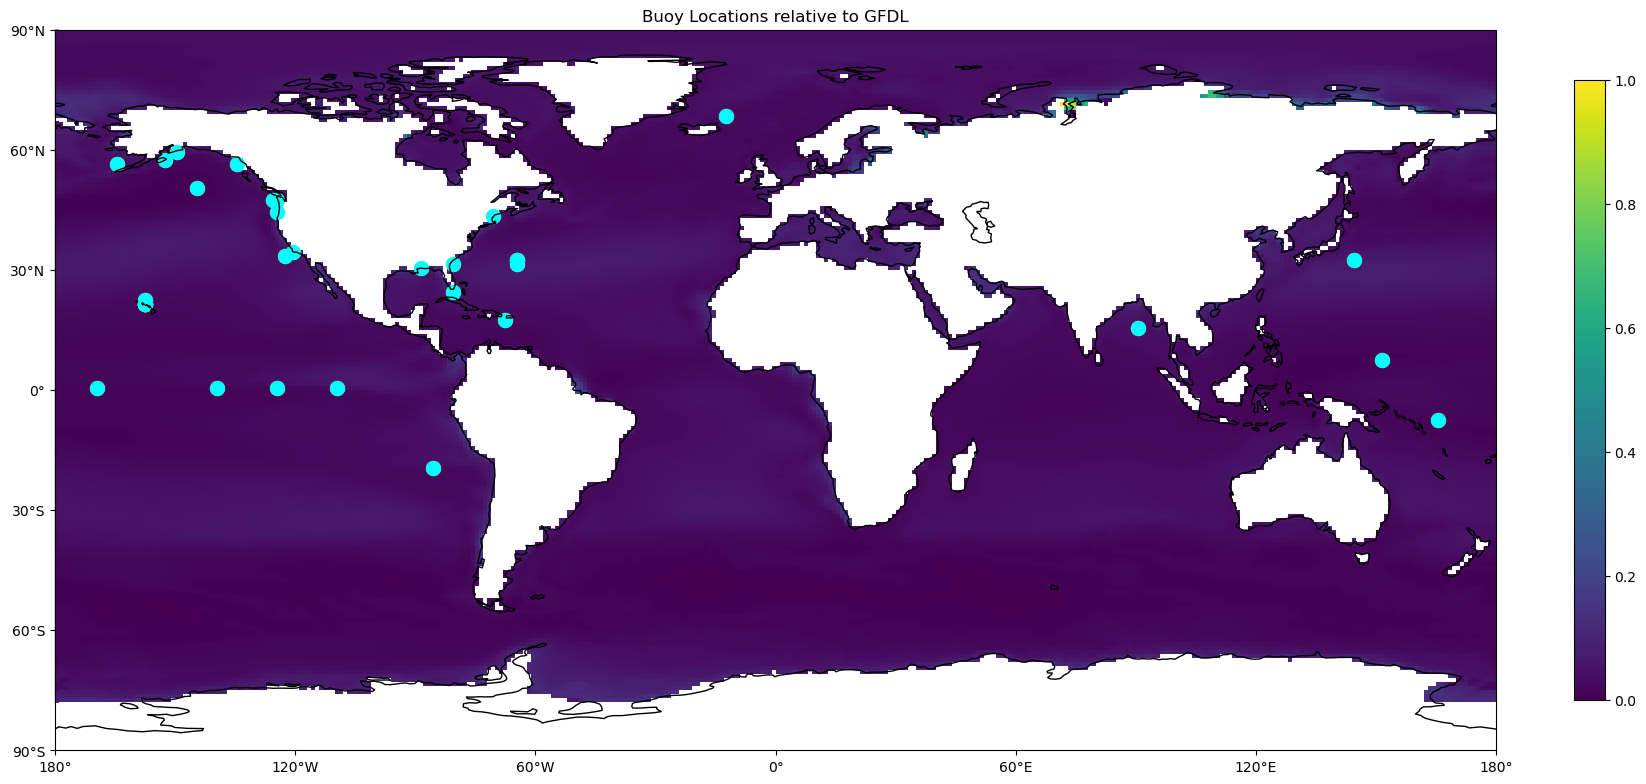

In [408]:
fig, ax = plt.subplots(figsize=[20,20], subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.pcolormesh(dsstd['x'], dsstd['y'], dsstd['fCO2_detrended'])
im = ax.scatter(dd['Longitude'], dd['Latitude'], c = 'yellow', s = 100)
im = ax.scatter(w, v, c = 'cyan', s = 100)
cbar = plt.colorbar(im, ax= ax, fraction = 0.02)
ax.set_title('Buoy Locations relative to GFDL')

# cbar = plt.colorbar(im, ax= ax, fraction = 0.02)
# ax.set_title('Buoy fCO2 Std')

ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# projPC = ccrs.PlateCarree()
# lonW = -140
# lonE = -40
# latS = 15
# latN = 65
# cLat = (latN + latS) / 2
# cLon = (lonW + lonE) / 2
# res = '110m'
# ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
# ax.coastlines(resolution=res, color='black')

# Add to csv with GFDL present

## GFDL 1995-2015

In [316]:
ds = xr.open_mfdataset('/Users/akbaskind/Desktop/YoE/GFDLESM4historical_1995_2015.nc')
ds['fCO2_detrended'] = (ds['fCO2'] -  1.89 * (ds['fCO2'].time.dt.year - 2000)) * xr.ones_like(ds['talkos'])
ds['ph_detrended'] = (ds['phos'] + 0.0018 * (ds['phos'].time.dt.year - 2000)) * xr.ones_like(ds['talkos'])
ds['OmegaAr_detrended'] = (ds['OmegaAr'] + 0.0078 * (ds['OmegaAr'].time.dt.year - 2000)) * xr.ones_like(ds['talkos'])
ds['fCO2_detrended'].attrs = {"units": 'uatm', 
                        'description': 'detrended fugacity. 1.89 uatm subtracted for every year since 2000',
                                 'name': 'fugacity detrended'}
ds['ph_detrended'].attrs = {"units": '', 'name': 'pH detrended', 
                        'description': 'detrended pH on total scale. 0.0018 added for every year since 2000'}
ds['OmegaAr_detrended'].attrs = {"units": '', 'name': 'Omega_arag detrended', 
                        'description': 'detrended Omega_arag calculated from PyCO2SYS: 0.0078 added for every year since 2000'}
ds

<xarray.Dataset>
Dimensions:            (y: 180, x: 360, time: 240)
Coordinates:
  * y                  (y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lat_bounds         (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
  * x                  (x) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    lon_bounds         (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
  * time               (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds        (time) object dask.array<chunksize=(240,), meta=np.ndarray>
    lon                (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat                (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lon_verticies      (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat_verticies      (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    member_id          object ...
    dcpp_init_year     float64 ...
Data variables:
    sos                (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    dissicos           (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    phos               (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    tos                (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    talkos             (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    sigma0             (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    fCO2               (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    OmegaAr            (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    fCO2_detrended     (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    ph_detrended       (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    OmegaAr_detrended  (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36500.0
    comment:                          <null ref>
    ...                               ...
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Omon
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:version:         20190726
    intake_esm_attrs:_data_format_:   zarr

### GFDL Std and mean

In [194]:
dsmean = ds.mean('time', keep_attrs = True)
dsstd = ds.std('time', keep_attrs = True)

I figured out why I was getting nan values when searching for the buoy coords in GFDL: GFDL longitude is 0 to 360 (as it SOCAT longitude), whereas buoy longitude is -180 to 180. I corrected this by searching for x values/longitudes using `x = lon % 360`. Then in this new dataset, I wrote longitudes in 0 to 360 form.

In [417]:
temp = {'Lat':[], 'Lon': [], 'GFDL Std Fugacity Detrended': [], 'Buoy Std Fugacity Detrended': [],
       'GFDL Std pH Detrended': [], 'Buoy Std pH Detrended': [],
       'GFDL Std OmegaAr Detrended': [], 'Buoy Std OmegaAr Detrended': []}
for n in dd.index:
    lat = dd['Latitude'].iloc[n]
    lon = dd['Longitude'].iloc[n]
    # for j in dd.Longitude:
    #     a = dd.where(dd['Latitude'] == i).where(dd['Longitude'] == j).dropna()
    b = dsstd.sel(x = lon % 360, y = lat, method = 'nearest')
    #     # dd.lat.values:
    #     # if math.isnan(dd['pH_sw_Std_detrended'].sel(lon = j, lat = i).values.tolist()) == False:
    #     if a.size > 0:
    temp['Lon'].append(lon % 360)
    temp['Lat'].append(lat)
    temp['GFDL Std Fugacity Detrended'].append(dsstd['fCO2_detrended'].sel(x = lon % 360, y = lat, method = 'nearest').values.tolist())
    temp['Buoy Std Fugacity Detrended'].append(dd['fCO2_detrended_Std'].iloc[n])
    temp['GFDL Std OmegaAr Detrended'].append(dsstd['OmegaAr_detrended'].sel(x = lon % 360, y = lat, method = 'nearest').values.tolist())
    temp['Buoy Std OmegaAr Detrended'].append(dd['OmegaAr_detrended_Std'].iloc[n])
    temp['GFDL Std pH Detrended'].append(dsstd['ph_detrended'].sel(x = lon % 360, y = lat, method = 'nearest').values.tolist())
    temp['Buoy Std pH Detrended'].append(dd['ph_detrended_Std'].iloc[n])

In [418]:
t = pd.DataFrame(temp, columns=['Lat', 'Lon', 'GFDL Std Fugacity Detrended', 'Buoy Std Fugacity Detrended', 'GFDL Std pH Detrended', 'Buoy Std pH Detrended','GFDL Std OmegaAr Detrended', 'Buoy Std OmegaAr Detrended'])
u = t
v = u['Lat']
w = u['Lon']

In [420]:
t.to_csv('/Users/akbaskind/Desktop/YoE/allbuoys_GFDL.csv')


In [421]:
#This is the Worksheet ID
spreadsheet_key = '1037dNJHlEJU1BtZsRmBnDBmy9Aiw6PvvFZ5i8MNA0VE'
#This is the sheet name
wks_name = 'with GFDL'
#We upload the tips data to our Google Sheet. Setting the row_names to False if you did not want the index to be included
d2g.upload(t, spreadsheet_key, wks_name, credentials=credentials, row_names=False)

<Worksheet 'with GFDL' id:556336624>